### Installing dependencies

In [ ]:
!pip install transformers
!pip install torch
!pip install datasets
!pip install accelerate -U
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 985.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=bbdfee1b99b5c0272561439e7962bdb7cf130a1b6dba913d3e5f0160ec625b68
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


### Importing useful packages

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import numpy as np

### Checking GPU availability

In [ ]:
if torch.cuda.is_available():
  device= torch.device("cuda")
  print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
  device= torch.device("cpu")
  print("Using CPU")

Using GPU: Tesla T4


### Loading the dataset

In [ ]:
raw_datasets = load_dataset("conll2003")
raw_datasets

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
raw_datasets["train"][1]["tokens"]

['Peter', 'Blackburn']

In [ ]:
raw_datasets["train"][1]["ner_tags"]

[1, 2]

### Extracting NER features

In [ ]:
ner_feature=raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

###Extracting NER Label Names

In [ ]:
label_names=ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

### Initializing Tokenizer from Pretrained Model

In [ ]:
model_checkpoint="bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Function for Aligning Labels with Tokens

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

### Example text

In [ ]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()
inputs.word_ids()

labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]


### Function for tokenization

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

### Apply the preprocessing on the raw datasets

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

### Data Collator for Token Classification

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

### Intialization and loading of Evaluation Metric

In [ ]:
%%capture
!pip install evaluate
import evaluate
metric = evaluate.load("seqeval")

### Definition of Custom Evaluation Metric

In [ ]:
import matplotlib.pyplot as plt
epochs=[]
precisions=[]
recalls=[]
f1_scores=[]
accuracies=[]

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    precision=all_metrics["overall_precision"]
    recall=all_metrics["overall_recall"]
    f1=all_metrics["overall_f1"]
    accuracy= all_metrics["overall_accuracy"]

    epochs.append(len(epochs)+1)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(accuracy)
    return{
        "precision":precision,
        "recall":recall,
        "f1":f1,
        "accuracy":accuracy
    }


### Defining Mapping between Label IDs and Labels (and vice versa)

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

### Loading Pretrained Model (bert-base-uncased)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Moving model to GPU

In [ ]:
model=model.to(device)

In [ ]:
model_checkpoint

'bert-base-uncased'

In [ ]:
model.config.num_labels

9

### Training Arguments Configuration

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

### Training Model Initialization

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

### Model Training

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.073800,0.059373,0.919510,0.934366,0.926878,0.984272
2,0.039100,0.052079,0.929007,0.949175,0.938983,0.986306
3,0.019800,0.066762,0.928088,0.946988,0.937443,0.986036
4,0.011100,0.068079,0.936587,0.949512,0.943005,0.987021
5,0.005400,0.073166,0.933058,0.950017,0.941461,0.987116


TrainOutput(global_step=8780, training_loss=0.040735392812172755, metrics={'train_runtime': 1012.8251, 'train_samples_per_second': 69.316, 'train_steps_per_second': 8.669, 'total_flos': 1489092270805854.0, 'train_loss': 0.040735392812172755, 'epoch': 5.0})

### Plotting the Metrics


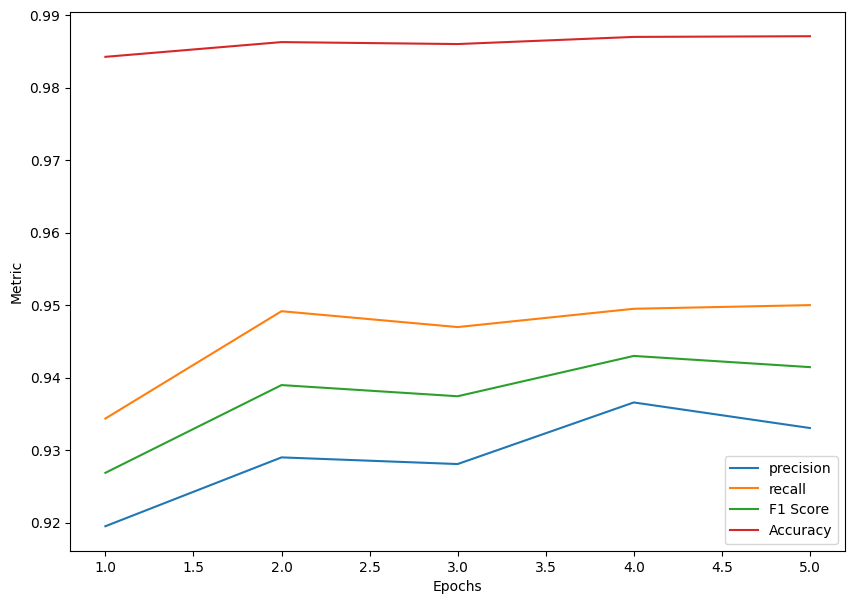

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(epochs, precisions, label="precision")
plt.plot(epochs, recalls, label="recall")
plt.plot(epochs, f1_scores, label="F1 Score")
plt.plot(epochs, accuracies, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.legend()
plt.show()